# **Import Libraries**

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from pathlib import Path
import pickle

import warnings
warnings.simplefilter('ignore')

sns.set_palette('viridis')
sns.set_style('whitegrid')

# **Load Data**

In [52]:
df = pd.read_csv(r'./train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [53]:
df.shape

(8523, 12)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [55]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [56]:
df.describe(include='O')

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


In [57]:
df.isna().mean() * 100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [58]:
df.duplicated().sum()

0

# **Data Cleaning**

## **Filling Missing Values for `Item_Weight`**
To fill the missing values in the `Item_Weight` column, we use the following approach:
- First, we create a dictionary (`weight_dict`) mapping each `Item_Identifier` to its respective `Item_Weight` for the rows where the weight is not missing.
- Then, we filter the rows where `Item_Weight` is missing (`filt`), and for those rows, we map the `Item_Identifier` to the dictionary to fill the missing `Item_Weight`.
- Finally, we remove any rows where `Item_Weight` is still missing after this operation.


In [59]:
weight_dict = df.dropna(subset=['Item_Weight', 'Item_Identifier']).set_index('Item_Identifier')['Item_Weight'].to_dict()
filt = df['Item_Weight'].isna()
df.loc[filt, 'Item_Weight'] = df.loc[filt, 'Item_Identifier'].map(weight_dict)

In [60]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                     4
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [61]:
# There are still 4 missing values, so I have chosen to drop them for cleaner analysis.
df=df[~df['Item_Weight'].isna()]

## **Standardizing the `Item_Fat_Content` Column**

The `Item_Fat_Content` column contains various representations of the same categories which can lead to inconsistencies in data analysis

- it's essential to standardize these labels




In [62]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [63]:
df['Item_Fat_Content'].replace({'low fat', 'LF'},'Low Fat',inplace=True)
df['Item_Fat_Content'].replace('reg','Regular',inplace=True)

## **Handling Missing in Outlet_Size**

In [64]:
df['Outlet_Size'].value_counts(dropna=False)

Outlet_Size
Medium    2790
NaN       2410
Small     2387
High       932
Name: count, dtype: int64

In [65]:
# Since the Outlet Size for existing Grocery Stores is Small, we will fill missing values in Outlet Size as Small for Grocery Stores
df.loc[df['Outlet_Type'] == 'Grocery Store','Outlet_Size'].unique()

array([nan, 'Small'], dtype=object)

In [66]:
df.loc[(df['Outlet_Size'].isna()) & (df['Outlet_Type']=='Grocery Store'),'Outlet_Size'] = 'Small'

In [67]:
df['Outlet_Size'].value_counts(dropna=False)

Outlet_Size
Small     2942
Medium    2790
NaN       1855
High       932
Name: count, dtype: int64

In [68]:
# Since the Outlet Size for existing Supermarket Type1 and Location Type is Tier 2 is Small, we will fill missing values in Outlet Size as Small for Supermarket Type1 and Tier 2
df.loc[(df['Outlet_Type']=='Supermarket Type1') & (df['Outlet_Location_Type']=='Tier 2'),'Outlet_Size'].unique()

array([nan, 'Small'], dtype=object)

In [69]:
df.loc[(df['Outlet_Type']=='Supermarket Type1') & (df['Outlet_Location_Type']=='Tier 2'),'Outlet_Size'] = 'Small'

In [70]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## **Save Cleaned Data**

In [71]:
df.to_csv('cleaned_data.csv', index = False)

# **EDA**

## **Univariate Analysis**

## Numeric Columns

In [72]:
palette = sns.color_palette('viridis')
def kdeplot_and_boxplot(df, columns):
    fig, ax = plt.subplots(4, 2, figsize = (30, 40))
    ax = ax.flatten()

    for i, col in enumerate(columns):
        sns.histplot(x = col, data=df, ax=ax[2 * i], color=palette[i], kde=True, lw=1.5, edgecolor='black')
        ax[2*i].set_title(col, fontweight = 'bold', fontfamily='serif', fontsize=20)
        sns.boxplot(x = col, data=df, ax=ax[2 * i+1], color=palette[i])
        ax[2 * i+1].set_title(col, fontweight = 'bold', fontfamily='serif', fontsize=20)

    plt.show()

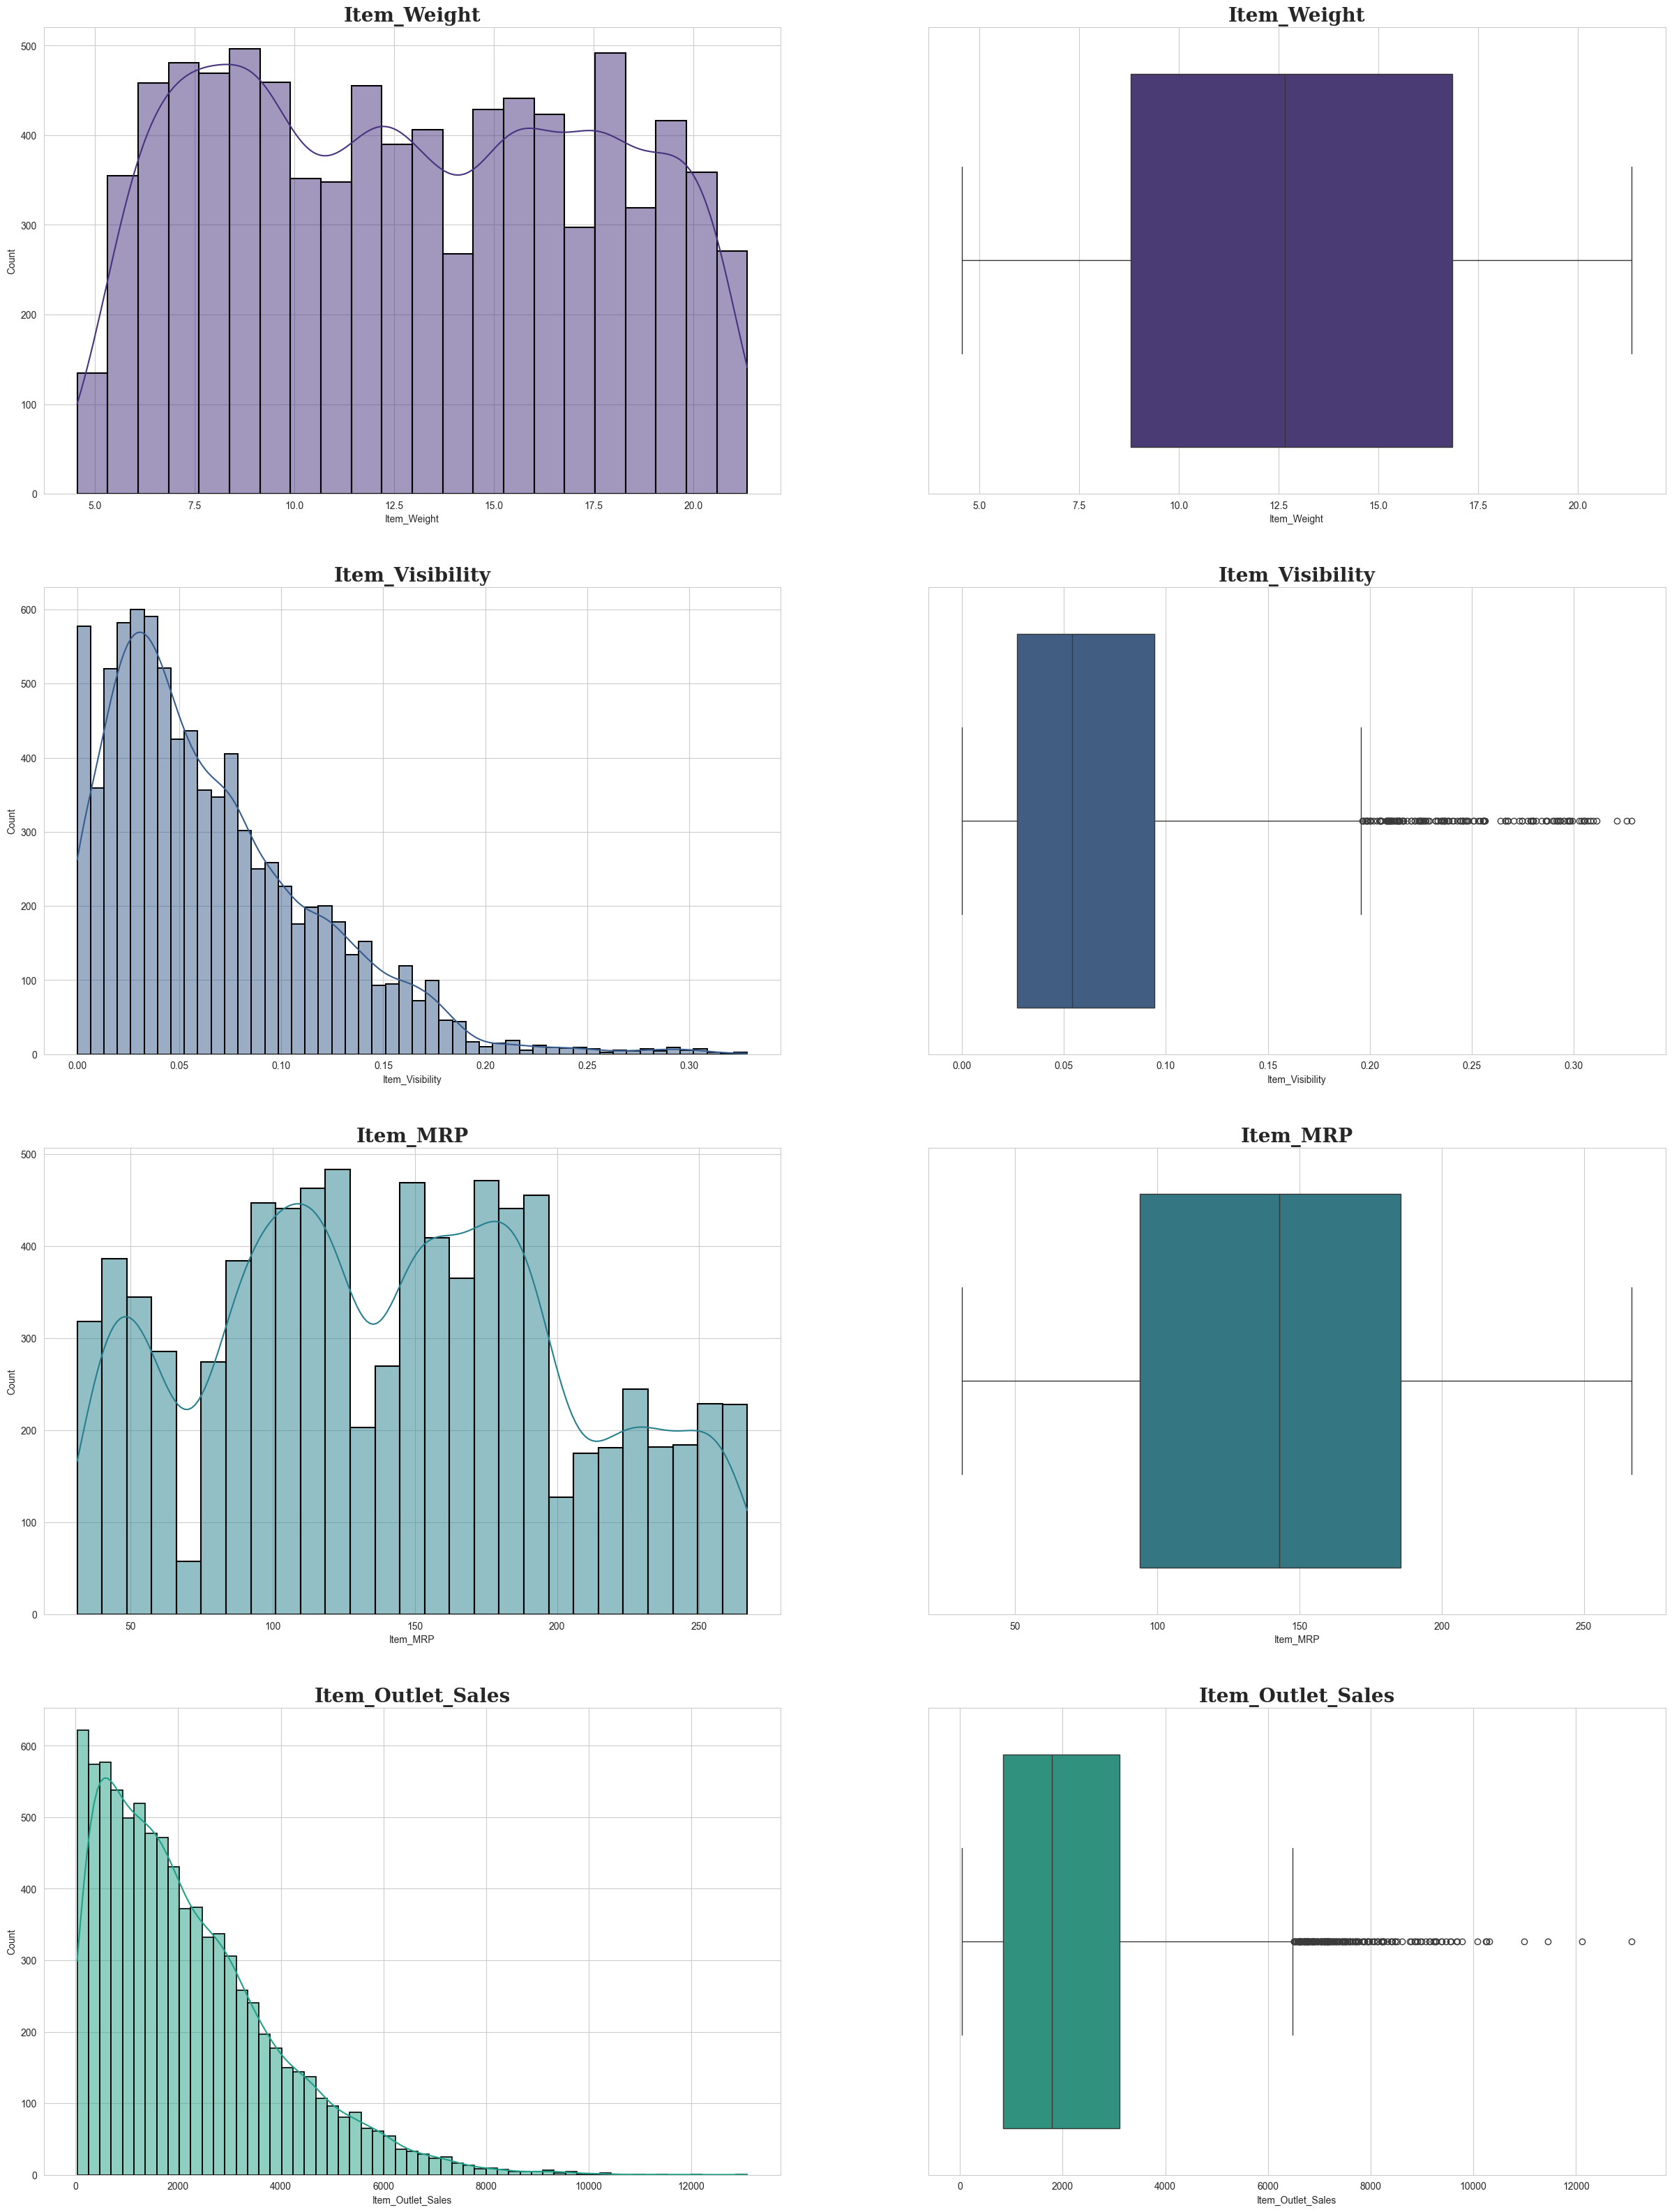

In [73]:
num_columns = ['Item_Weight','Item_Visibility','Item_MRP','Item_Outlet_Sales']
kdeplot_and_boxplot(df,num_columns)

## Category Columns

In [74]:
def pie_plot(columns,df):
    num_columns = 2
    num_rows = 3

    fig,axes = plt.subplots(num_rows,num_columns,figsize=(14,12))
    axes = axes.flatten()
    for i,column in enumerate(columns):
        counts = df[column].value_counts()
        palette = sns.color_palette('viridis',df[column].nunique())

        axes[i].pie(counts.values,labels=counts.index,autopct='%.2f%%',colors=palette)
        axes[i].set_title(f'{column} Distribution',fontsize=20,fontweight='bold')

    for j in range(len(columns), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [75]:
df_cp =  df.copy()
item_counts = df_cp['Item_Type'].value_counts()

def categorize_item_type(item_type):
    if item_counts[item_type] < 445:
        return 'Others'
    return item_type

df_cp['Item_Type'] = df_cp['Item_Type'].apply(categorize_item_type)
df_cp['Item_Type'].value_counts()

Item_Type
Others                   1381
Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Name: count, dtype: int64

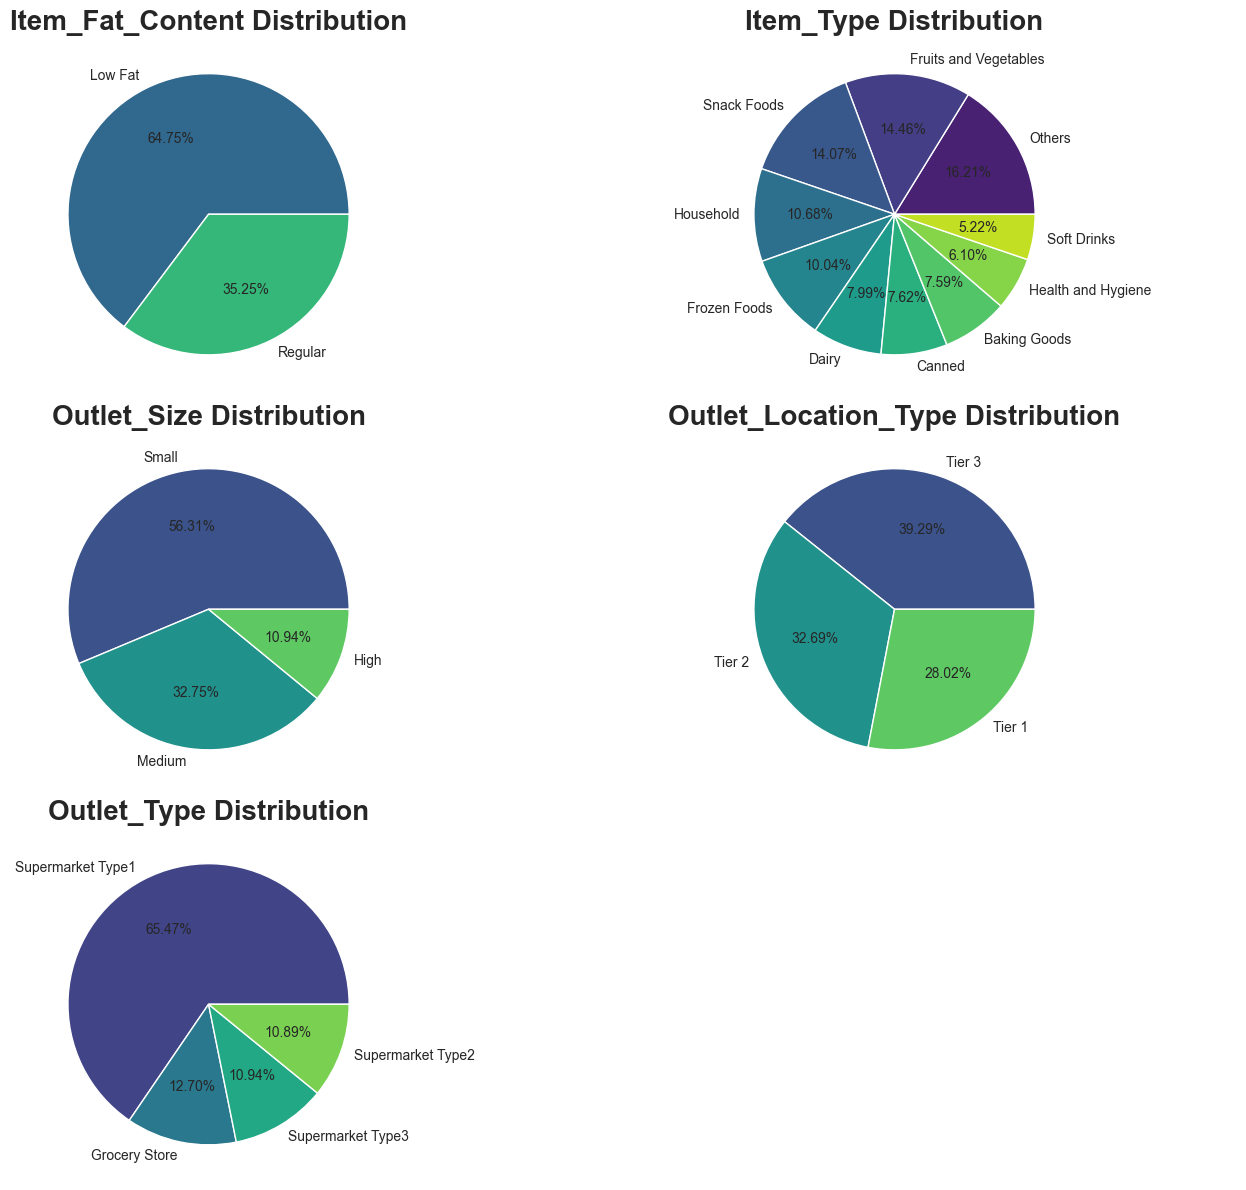

In [76]:
cat_columns = ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type']
pie_plot(cat_columns,df_cp)

## **Bivariate Analysis**

## Item MRP (Maximum Retail Price) vs. Sales

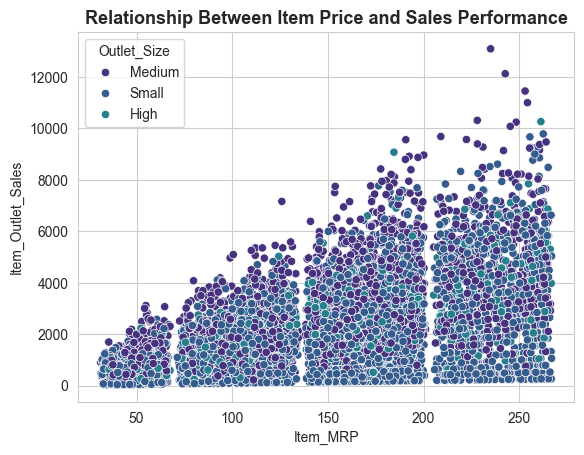

In [77]:
sns.scatterplot(x='Item_MRP',y='Item_Outlet_Sales',hue='Outlet_Size',data=df)

plt.title('Relationship Between Item Price and Sales Performance',fontsize=13,fontweight='bold')
plt.show()

## Outlet Type vs. Sales

In [78]:
type_sales = df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False).reset_index()
type_sales

,Outlet_Type,Item_Outlet_Sales
0,Supermarket Type3,3695.781505
1,Supermarket Type1,2316.181148
2,Supermarket Type2,1995.498739
3,Grocery Store,340.031198


Text(0.5, 1.0, 'Outlet Type vs. Sales')

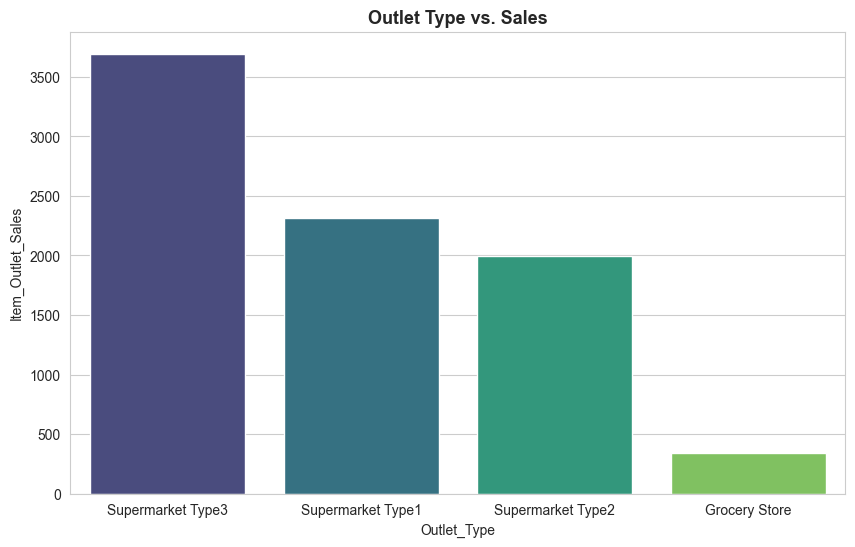

In [79]:
plt.figure(figsize=(10,6))
sns.barplot(x='Outlet_Type',y='Item_Outlet_Sales',data=type_sales,palette='viridis')
plt.title('Outlet Type vs. Sales',fontsize=13,fontweight='bold')

## Outlet Location vs. Sales

In [80]:
location_sales = df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().reset_index().sort_values(by='Outlet_Location_Type')
location_sales

,Outlet_Location_Type,Item_Outlet_Sales
0,Tier 1,1877.644978
1,Tier 2,2323.990559
2,Tier 3,2278.845218


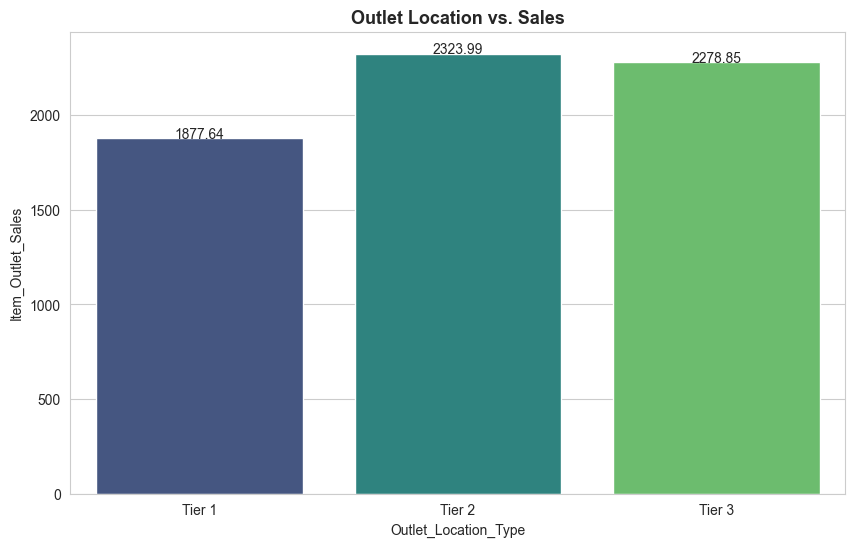

In [81]:
plt.figure(figsize=(10,6))
sns.barplot(x='Outlet_Location_Type',y='Item_Outlet_Sales',data=location_sales,palette='viridis')
plt.title('Outlet Location vs. Sales',fontsize=13,fontweight='bold')

for index, value in enumerate(location_sales['Item_Outlet_Sales']):
    plt.text(index, value + 0.02, round(value, 2), ha="center")

## Outlet Size vs. Sales

In [82]:
size_sales = df.groupby('Outlet_Size')['Item_Outlet_Sales'].mean().reset_index()
size_sales

,Outlet_Size,Item_Outlet_Sales
0,High,2298.995256
1,Medium,2681.097134
2,Small,1867.546932


Text(0.5, 1.0, 'Outlet_Size')

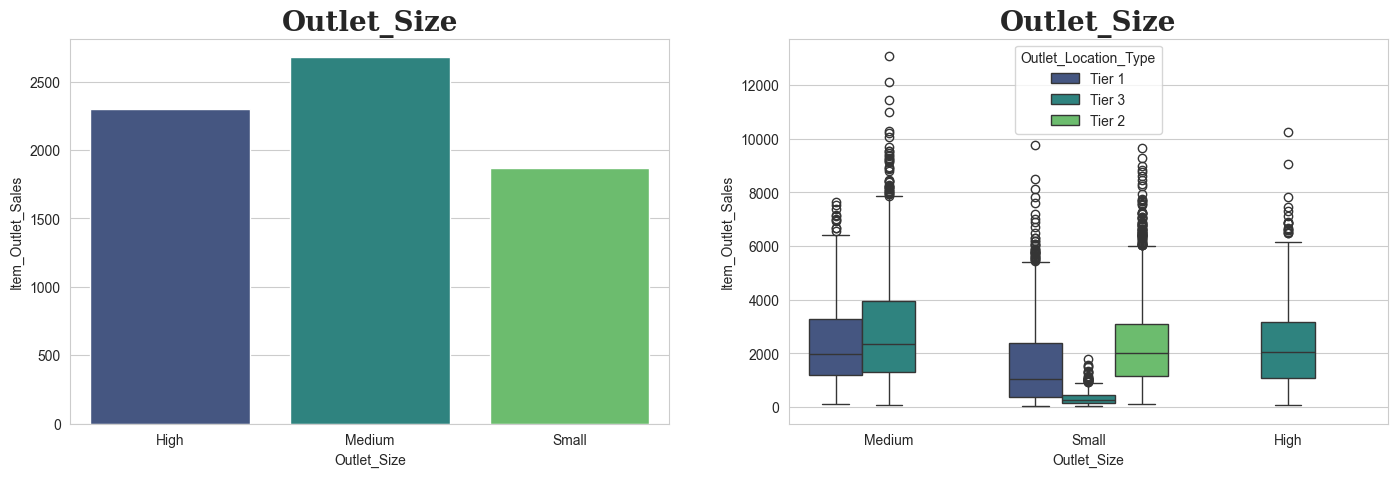

In [83]:
fig, ax = plt.subplots(1, 2, figsize = (17, 5))

sns.barplot(x='Outlet_Size',y='Item_Outlet_Sales',data=size_sales,ax=ax[0],palette='viridis')
ax[0].set_title('Outlet_Size', fontweight = 'bold', fontfamily='serif', fontsize=20)
sns.boxplot(x='Outlet_Size',y='Item_Outlet_Sales',hue='Outlet_Location_Type',data=df,ax=ax[1],palette='viridis')
ax[1].set_title('Outlet_Size', fontweight = 'bold', fontfamily='serif', fontsize=20)

## Item Fat Content vs. Sales

In [84]:
fat_sales = df.groupby('Item_Fat_Content')['Item_Outlet_Sales'].mean().reset_index()
fat_sales

,Item_Fat_Content,Item_Outlet_Sales
0,Low Fat,2157.298823
1,Regular,2225.070565


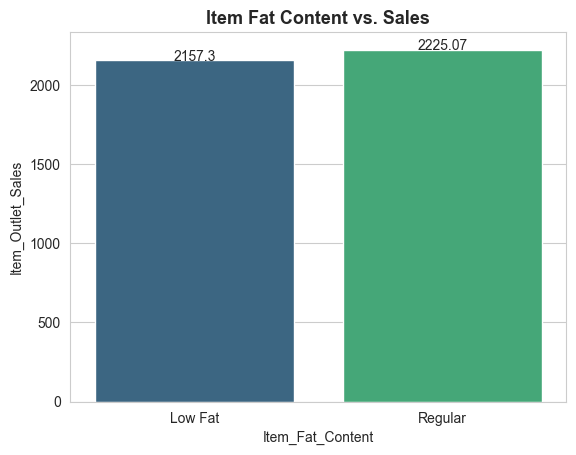

In [85]:
sns.barplot(x='Item_Fat_Content',y='Item_Outlet_Sales',data=fat_sales,palette='viridis')
plt.title('Item Fat Content vs. Sales',fontsize=13,fontweight='bold')

for index, value in enumerate(fat_sales['Item_Outlet_Sales']):
    plt.text(index, value + 0.02, round(value, 2), ha="center")

## Item Type vs. Sales

In [86]:
item_type = df.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False).reset_index()
item_type

,Item_Type,Item_Outlet_Sales
0,Starchy Foods,2374.332773
1,Seafood,2326.065928
2,Fruits and Vegetables,2289.009592
3,Snack Foods,2275.522818
4,Household,2258.784300
5,Dairy,2230.749701
6,Canned,2225.194904
7,Breads,2204.132226
8,Meat,2158.977911
9,Hard Drinks,2139.221622


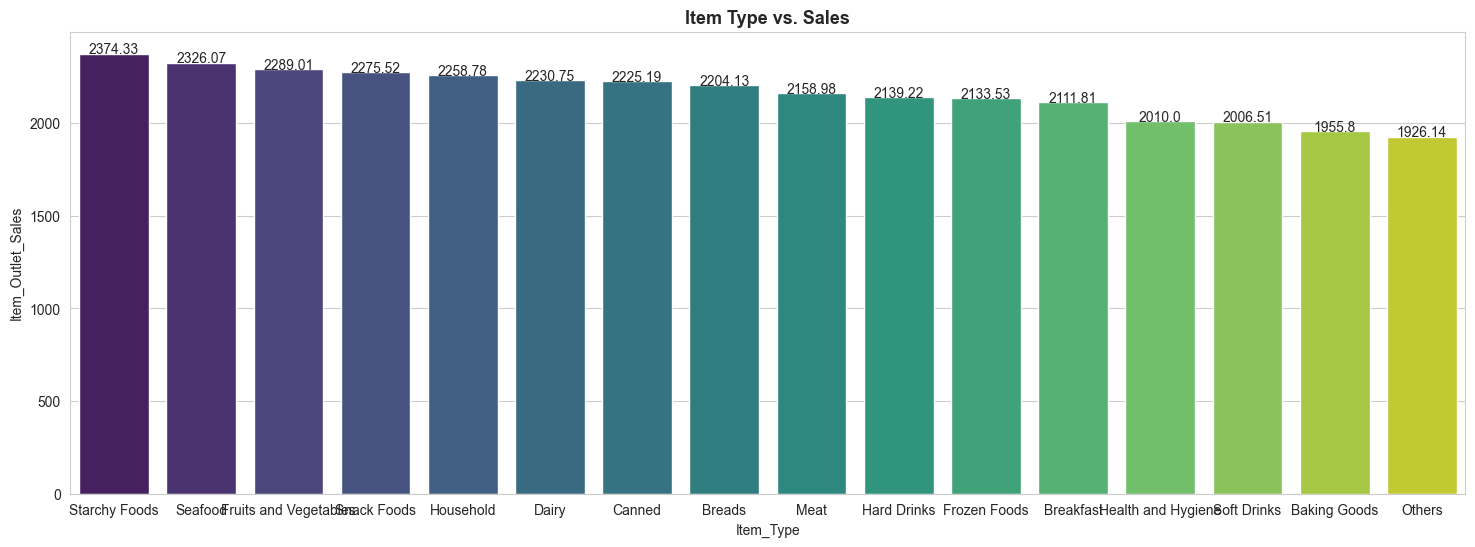

In [87]:
plt.figure(figsize=(18,6))

sns.barplot(x='Item_Type',y='Item_Outlet_Sales',data=item_type,palette='viridis')
plt.title('Item Type vs. Sales',fontsize=13,fontweight='bold')

for index, value in enumerate(item_type['Item_Outlet_Sales']):
    plt.text(index, value + 0.02, round(value, 2), ha="center")

plt.show()

## Outlet Establishment Year vs. Sales

In [88]:
year_sales = df.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].mean().sort_values(ascending=False).reset_index()
year_sales

,Outlet_Establishment_Year,Item_Outlet_Sales
0,1985,2483.921827
1,2004,2438.841866
2,1999,2348.354635
3,2007,2340.675263
4,1987,2298.995256
5,1997,2277.844267
6,2002,2192.384798
7,2009,1995.498739
8,1998,339.351662


Text(0.5, 1.0, 'Outlet Establishment Year vs. Sales')

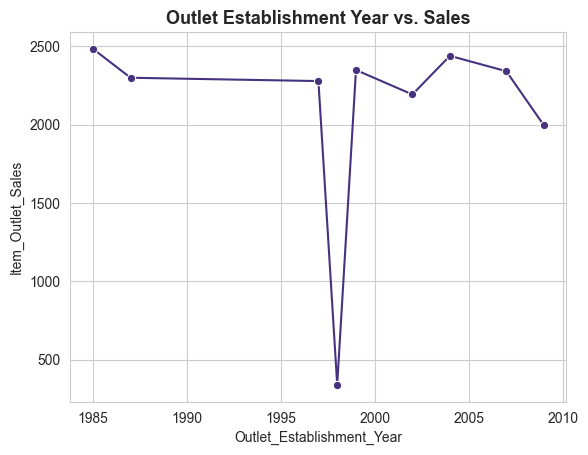

In [89]:
sns.lineplot(x='Outlet_Establishment_Year',y='Item_Outlet_Sales',data=year_sales,marker='o')
plt.title('Outlet Establishment Year vs. Sales',fontsize=13,fontweight='bold')

## Correlation

<Axes: >

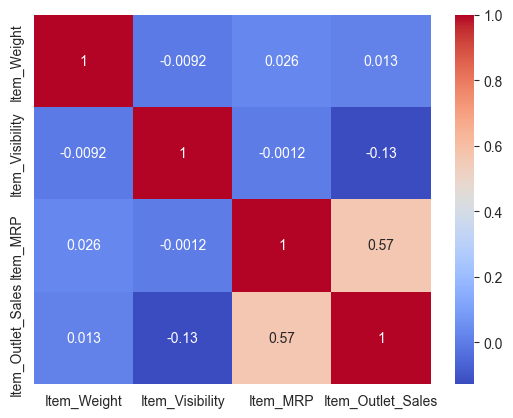

In [90]:
sns.heatmap(df[num_columns].corr(),cmap='coolwarm',annot=True)

# **Modeling**

<Axes: >

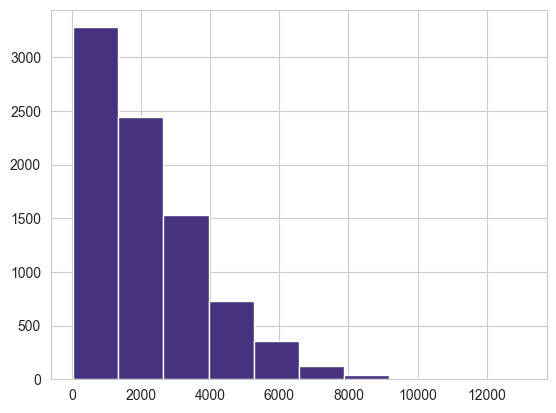

In [91]:
df['Item_Outlet_Sales'].hist()

To reduce the skewness in the `Item_Outlet_Sales` column, we apply a logarithmic transformation

<Axes: >

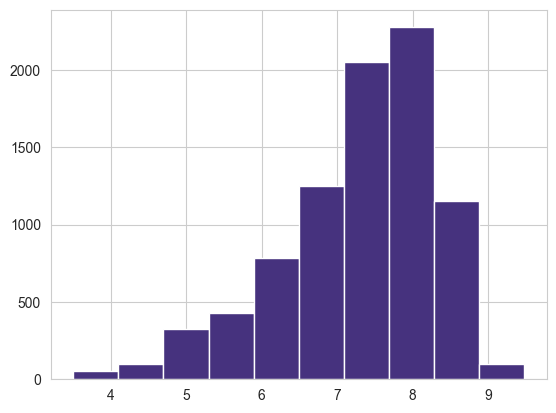

In [92]:
np.log(df['Item_Outlet_Sales']).hist()

In [93]:
num_columns = ['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year']

nominal_columns = ['Item_Type','Outlet_Location_Type','Outlet_Type','Outlet_Identifier']
ordinal_columns = ['Item_Fat_Content','Outlet_Size']

## **Perpare PipeLine**

In [94]:
num_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler',StandardScaler())
    ])

ordinal_pipeline = Pipeline([
    ('ord_encoder',OrdinalEncoder())
])

nominal_pipeline = Pipeline([
    ('nom_encoder',OneHotEncoder(drop='first',sparse_output = False))
])

preprocessor = ColumnTransformer([
    ('num_pipeline',num_pipeline,num_columns),
    ('ordinal_pipeline',ordinal_pipeline,ordinal_columns),
    ('nominal_pipeline',nominal_pipeline,nominal_columns)
]).set_output(transform = 'pandas')

In [95]:
# One Split for Validation
X = df.drop(['Item_Outlet_Sales','Item_Identifier'], axis = 1)
y = np.log(df['Item_Outlet_Sales'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print('X_train shape -- ', X_train.shape)
print('y_train shape -- ', y_train.shape)
print('X_Validtrain shape -- ', X_valid.shape)
print('y_Valid shape -- ', y_valid.shape)
print('X_test shape -- ', X_test.shape)
print('y_test shape -- ', y_test.shape)

X_train shape --  (5452, 10)
y_train shape --  (5452,)
X_Validtrain shape --  (1363, 10)
y_Valid shape --  (1363,)
X_test shape --  (1704, 10)
y_test shape --  (1704,)


## **Fine Tuning**

In [101]:
import lightgbm as lgb

In [97]:
models = [
    Pipeline([('preprocessor', preprocessor), ('LinearReg', LinearRegression())]),
    Pipeline([('preprocessor', preprocessor), ('Ridge', Ridge())]),
    Pipeline([('preprocessor', preprocessor), ('RandomForest', RandomForestRegressor())]),
    Pipeline([('preprocessor', preprocessor), ('XGBRegressor', XGBRegressor())]),
    Pipeline([('preprocessor', preprocessor), ('LGBM', lgb.LGBMRegressor())])  # Adding LightGBM model
]

# Define hyperparameters for each model
params = [
    # Parameters for Linear Regression
    {'preprocessor__num_pipeline__poly__degree': [1, 2, 3, 4, 5]},

    # Parameters for Ridge Regression
    {'preprocessor__num_pipeline__poly__degree': [1, 2, 3, 4, 5],
     'Ridge__alpha': [0.01, 0.1, 1, 10, 100]},

    # Parameters for Random Forest
    {'preprocessor__num_pipeline__poly__degree': [1, 3],
     'RandomForest__n_estimators': [50, 100],
     'RandomForest__max_depth': [10, 20]},

    # Parameters for XGBoost
    {'preprocessor__num_pipeline__poly__degree': [2, 3, 4, 5],
     'XGBRegressor__n_estimators': [50, 100],
     'XGBRegressor__learning_rate': [0.01, 0.1, 0.2],
     'XGBRegressor__max_depth': [3, 4, 5],
     'XGBRegressor__gamma': [0, 0.1, 0.2]},

    # Parameters for LightGBM (LGBM)
    {'preprocessor__num_pipeline__poly__degree': [2, 3, 4],
     'LGBM__n_estimators': [50, 100],
     'LGBM__learning_rate': [0.01, 0.05, 0.1],
     'LGBM__max_depth': [5, 10, -1],  # -1 for no limit on depth
     'LGBM__num_leaves': [31, 50, 100]}
]

# Initialize variables to store results
grid_search = []
results = []
model_names = ['Linear_Regression', 'Ridge_Regression', 'Random_Forest', 'XGBoost', 'LightGBM']
predictions = {}

# Run GridSearchCV for each model
for model, param_grid, model_name in zip(models, params, model_names):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    grid_search.append(grid)

    # Best Params and Best Score
    print(f'{model_name} - Best Params: {grid.best_params_}')
    print(f'{model_name} - Best R² Score: {grid.best_score_:.4f}')

    best_model = grid.best_estimator_
    y_valid_pred = best_model.predict(X_valid)
    predictions[model_name] = y_valid_pred  # Store the predictions for later use

    # Calculate Metrics
    mae = mean_absolute_error(y_valid, y_valid_pred)
    mse = mean_squared_error(y_valid, y_valid_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid, y_valid_pred)

    # Store results
    results.append({
        'Model': model_name,
        'Best Params': grid.best_params_,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

    # Save the best model
    model_filename = f"{model_name}_best_model.pkl"
    pickle.dump(best_model, open(model_filename, 'wb'))
    print(f"Model {model_name} saved as {model_filename}")

    # Print results
    print(f'{model_name} - MAE: {mae:.5f}')
    print(f'{model_name} - MSE: {mse:.5f}')
    print(f'{model_name} - RMSE: {rmse:.5f}')
    print(f'{model_name} - R²: {r2:.5f}')
    print('----------------------------------------------------------------------------------------------------------------')

# Convert results to DataFrame
df_vald_results = pd.DataFrame(results)

# Create a DataFrame to display predictions for all models
predictions_df = pd.DataFrame(predictions)

# Display predictions for each model
print("Predictions for all models:")
print(predictions_df)

Linear_Regression - Best Params: {'preprocessor__num_pipeline__poly__degree': 3}
Linear_Regression - Best R² Score: 0.7398
Model Linear_Regression saved as Linear_Regression_best_model.pkl
Linear_Regression - MAE: 0.42226
Linear_Regression - MSE: 0.30012
Linear_Regression - RMSE: 0.54783
Linear_Regression - R²: 0.71208
----------------------------------------------------------------------------------------------------------------
Ridge_Regression - Best Params: {'Ridge__alpha': 1, 'preprocessor__num_pipeline__poly__degree': 3}
Ridge_Regression - Best R² Score: 0.7404
Model Ridge_Regression saved as Ridge_Regression_best_model.pkl
Ridge_Regression - MAE: 0.41998
Ridge_Regression - MSE: 0.29849
Ridge_Regression - RMSE: 0.54634
Ridge_Regression - R²: 0.71365
----------------------------------------------------------------------------------------------------------------
Random_Forest - Best Params: {'RandomForest__max_depth': 10, 'RandomForest__n_estimators': 100, 'preprocessor__num_pipeli

In [98]:
df_vald_results.sort_values(by='R²',ascending=False)

,Model,Best Params,MAE,MSE,RMSE,R²
4,LightGBM,"{'LGBM__learning_rate': 0.05, 'LGBM__max_depth...",0.420583,0.296246,0.544285,0.715798
3,XGBoost,"{'XGBRegressor__gamma': 0, 'XGBRegressor__lear...",0.420136,0.297228,0.545186,0.714856
1,Ridge_Regression,"{'Ridge__alpha': 1, 'preprocessor__num_pipelin...",0.419979,0.298486,0.546339,0.713649
0,Linear_Regression,{'preprocessor__num_pipeline__poly__degree': 3},0.422261,0.300120,0.547832,0.712082
2,Random_Forest,"{'RandomForest__max_depth': 10, 'RandomForest_...",0.426585,0.303909,0.551280,0.708446


## **Test Model**

In [99]:
results = []
current_model = 0

# Loop through all model files with ".pkl" extension
for model_path in Path("/kaggle/working/").rglob("*.pkl"):
    try:
        # Load the model
        model = pickle.load(open(model_path, "rb"))

        X_test_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, X_test_pred)
        mse = mean_squared_error(y_test, X_test_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, X_test_pred)

        result = {
            'Model': model_path.stem,  # Get the model name from the file path
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2
        }

        if hasattr(model, 'best_params_'):
            result['Best Params'] = model.best_params_

        results.append(result)

        print(f"Evaluation for {model_path.stem} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
        if 'Best Params' in result:
            print(f"Best Params: {result['Best Params']}")

    except Exception as e:
        print(f"Error processing {model_path.stem}: {e}")

    current_model += 1
    print(f"Processed {current_model} models")

df_results = pd.DataFrame(results)

# **Results**